## BERT model construction with 'Toxicity' and 'Gab' data


2020/10/22

In this version, we augmented the toxicity and gab data together based on the manually created 'racism_word.csv', then we test the model on different data sets.

Student: Xuanyu Su                                                                 
Supervisor: Isar Nejadgholi

# Data import

In [3]:
pip install emoji

     |████████████████████████████████| 51kB 5.3MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49716 sha256=a3d2c30201634c7d78317c98fd3a8447730f0e3c5794cb70510ea4b1345d52fb
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
Successfully built emoji


In [41]:
pip install torch

In [4]:
pip install transformers

     |████████████████████████████████| 1.3MB 8.3MB/s 
     |████████████████████████████████| 2.9MB 34.1MB/s 
     |████████████████████████████████| 1.1MB 50.5MB/s 
     |████████████████████████████████| 890kB 48.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=41958f84d062a98e57c291332bc4fe2d2995abb65ae520c46c64c67dfb059b5e
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [5]:
source_folder = 'Data'
destination_folder = 'Model'

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd

racism_word = pd.read_csv('/content/drive/My Drive/racism_word.csv', sep=',',encoding = "ISO-8859-1")
GAB = pd.read_csv('Data/GabHateCorpus_annotations.tsv', sep='\t',encoding = "ISO-8859-1")
tox_train = pd.read_csv('Data/Toxicity_Train_comment.csv',sep=',',encoding = "ISO-8859-1")
tox_val = pd.read_csv('Data/Toxicity_Val_comment.csv',sep=',',encoding = "ISO-8859-1")
tox_test = pd.read_csv('Data/Toxicity_Test_comment.csv',sep=',',encoding = "ISO-8859-1")

# Prepreocess Racism_word table

In [8]:
racism_word.head()

,Content,Unnamed: 1
0,Abbie,NaN
1,Abe,NaN
2,Abie,NaN
3,ABC,NaN
4,ABCD,NaN


In [9]:
# process racism word table
#import the racism keywords list
import re
racist_word_list = racism_word['Content']

# drop unretaltes column in racism word table and convert all to lower
new_racism_word = racism_word.drop(columns = ['Unnamed: 1'])
new_racism_word['Content'] = new_racism_word['Content'].apply(lambda x:re.sub(r'[^A-Za-z0-9 ]+', ' ', x).lower())
new_racism_word.head()

,Content
0,abbie
1,abe
2,abie
3,abc
4,abcd


# Preprocess Gab data

In [10]:
GAB.head()

,ID,Annotator,Text,Hate,HD,CV,VO,REL,RAE,SXO,GEN,IDL,NAT,POL,MPH,EX,IM
0,27044,4,Ah the PSYOPS antifa crew is back. Thatâs ho...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,27044,15,Ah the PSYOPS antifa crew is back. Thatâs ho...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,27044,10,Ah the PSYOPS antifa crew is back. Thatâs ho...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,27044,8,Ah the PSYOPS antifa crew is back. Thatâs ho...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,27045,4,Get the new Android app update released today ...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# voting the duplicates
new_label = GAB.groupby('ID')['Hate'].mean() > 0.5

#  tmp label list
temp = []
for i in new_label:
    if i is True:
        temp.append(1.0)
    else:
        temp.append(0.0)
new_label = temp

# drop previous duplicated list
new_GAB = GAB.drop_duplicates(subset=['ID'])

# assign new label list to table
new_GAB['Hate'] = temp

new_GAB = new_GAB[['Text','Hate']]
new_GAB = new_GAB.reset_index(drop = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
new_GAB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27665 entries, 0 to 27664
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Text    27665 non-null  object 
 1   Hate    27665 non-null  float64
dtypes: float64(1), object(1)
memory usage: 432.4+ KB


In [13]:
# class of data preprocessing
import re
from tqdm import tqdm
import emoji

class Word_Preprocessing():
    def eliminate_url(self,df,target):
        print('Start eliminate url: : )')
        df_temp = df
        target_column_name = target
        text = df_temp[target_column_name]
        for i in tqdm(text):
            urls = re.findall(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})', i)
            for i in urls:
                df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(i, ""))
        return df_temp
    
    def eliminate_username(self,df,target):
        print('Start eliminate username: : )')
        df_temp = df
        target_column_name = target
        for i in tqdm(df_temp[target_column_name]):
            user_name = re.findall(r'@\w*', i)
            for i in user_name:
                df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(i, ""))
        return df_temp
    
    
    def eliminate_hashtag(self, df, target):
        df_temp = df
        target_column_name = target
        for i in tqdm(df_temp[target_column_name]):
            user_name = re.findall(r'#\w*', i)
            for i in user_name:
                df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(i, ""))
        return df_temp
    
    def eliminate_symbol(self,df,target):
        print('Start eliminate symbol: : )')
        df_temp = df
        target_column_name = target
        symbol_list = ['!','@','#','$','%','^','&','*','(',')','-','+','?','>','<','=','/','.',':',';','  ','   ','    ','      ','      ','  ']
        for i in tqdm(symbol_list):
            df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(i, ' '))
        return df_temp
    
    def to_Lower(self,df,target):
        df_temp = df
        target_column_name = target
        print('Start eliminate lower: : )')
        df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x:re.sub(r'[^A-Za-z0-9 ]+', ' ', x).lower())
        return df_temp
    
    def eliminate_emoji(self,df,target):
        print('Start transfer emoji: : )')
        df_temp = df
        target_column_name = target
        preprocessed_text = []
        df_temp[target_column_name] = df_temp.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))
        return df_temp
    
    def process_all(self, df,target):
        df_temp = df
        target_column_name = target
        df_remove_url = self.eliminate_url(df_temp,target_column_name)
        df_transfer_emoji = self.eliminate_emoji(df_remove_url, target_column_name)
        df_eliminate_hashtag = self.eliminate_hashtag(df_transfer_emoji, target_column_name)
        df_remove_username = self.eliminate_username(df_eliminate_hashtag, target_column_name)
        df_remove_symbol = self.eliminate_symbol(df_remove_username, target_column_name)
        df_to_lower = self.to_Lower(df_remove_symbol, target_column_name)
        print("finished!!")
        return df_to_lower   

In [14]:
word_preprocesser = Word_Preprocessing()
new_GAB1 = word_preprocesser.process_all(new_GAB, 'Text')

  0%|          | 13/27665 [00:00<03:32, 129.91it/s]

Start eliminate url: : )


  0%|          | 0/27665 [00:00<?, ?it/s]

Start transfer emoji: : )


  1%|          | 306/27665 [00:00<00:22, 1237.35it/s]

Start eliminate username: : )


 46%|████▌     | 12/26 [00:00<00:00, 115.60it/s]

Start eliminate symbol: : )


100%|██████████| 26/26 [00:00<00:00, 97.20it/s] 


Start eliminate lower: : )
finished!!


# start extrcting racism word from both gab and toxicity

In [15]:
# define find hate sentence function
import numpy as np
def find_hate_sentence(df, keyword, label, checklist):
    hate_sentence = []
    hate_label = []
    for i in tqdm(range(len(df))):  
      temp_df = df.iloc[i]
      for j in checklist:
        if j in temp_df[keyword]:
          hate_sentence.append(temp_df[keyword])
          hate_label.append(temp_df[label])
    hate = {'Text':hate_sentence, 'Label':hate_label}
    hate = pd.DataFrame(hate)
    hate = hate.drop_duplicates(subset=[keyword])
    return hate

In [16]:
# apply find hate function in gab data
hate_keyword = new_racism_word['Content']
hate_gab = find_hate_sentence(new_GAB1, 'Text', 'Hate', hate_keyword)

100%|██████████| 27665/27665 [00:49<00:00, 561.96it/s]


In [17]:
# change the column name of hate in gab into toxicity
hate_gab.rename(index=str, columns={"Label": "toxicity", 'Text':'comment'},inplace=True)
hate_gab.head()

,comment,toxicity
0,these companies are run by sociopaths he sa...,0.0
1,cnn mocked over self important facts first ad ...,1.0
2,joseph kleitsch selfportrait hungarian ameri...,0.0
3,teachable moment this week patriots anons as y...,0.0
4,the world is a better safer place now that mcc...,0.0


In [19]:
hate_gab.info()
# 5860 in 27665
hate_gab.to_csv('Data/data_after_extraction/hate_gab.csv',index=False,header=True)

<class 'pandas.core.frame.DataFrame'>
Index: 5860 entries, 0 to 7011
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   comment   5860 non-null   object 
 1   toxicity  5860 non-null   float64
dtypes: float64(1), object(1)
memory usage: 137.3+ KB


In [22]:
# define find hate sentence function
import numpy as np
def find_hate_sentence(df, keyword, label, checklist):
    hate_sentence = []
    hate_label = []
    for i in tqdm(range(len(df))):  
      temp_df = df.iloc[i]
      for j in checklist:
        if j in temp_df[keyword]:
          hate_sentence.append(temp_df[keyword])
          hate_label.append(temp_df[label])
    hate = {'comment':hate_sentence, 'toxicity':hate_label}
    hate = pd.DataFrame(hate)
    hate = hate.drop_duplicates(subset=[keyword])
    return hate

In [23]:
tox_train.head()

,comment,toxicity
0,this one can make an analogy in mathematical t...,0.0
1,clarification for you and zundark s right i...,0.0
2,this is such a fun entry devotchka i once had...,0.0
3,i fixed the link i also removed homeopathy ...,0.0
4,if they are indisputable then why does the ...,0.0


In [24]:
# apply find hate function in toxicity data
hate_keyword = new_racism_word['Content']
hate_tox_train = find_hate_sentence(tox_train, 'comment', 'toxicity', hate_keyword)


100%|██████████| 36617/36617 [01:15<00:00, 487.43it/s]


In [25]:
hate_tox_train.info()
hate_tox_train.to_csv('Data/data_after_extraction/hate_tox_train.csv',index=False,header=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13273 entries, 0 to 19537
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   comment   13273 non-null  object 
 1   toxicity  13273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 311.1+ KB


In [27]:
hate_tox_val = find_hate_sentence(tox_val, 'comment', 'toxicity', hate_keyword)



  0%|          | 0/32128 [00:00<?, ?it/s]

  0%|          | 44/32128 [00:00<01:13, 436.49it/s]

  0%|          | 90/32128 [00:00<01:12, 442.98it/s]

  0%|          | 141/32128 [00:00<01:09, 459.51it/s]

  1%|          | 194/32128 [00:00<01:06, 477.85it/s]

  1%|          | 244/32128 [00:00<01:05, 483.61it/s]

  1%|          | 296/32128 [00:00<01:04, 493.82it/s]

  1%|          | 350/32128 [00:00<01:02, 505.69it/s]

  1%|          | 399/32128 [00:00<01:03, 500.77it/s]

  1%|▏         | 451/32128 [00:00<01:02, 505.57it/s]

  2%|▏         | 500/32128 [00:01<01:03, 498.30it/s]

  2%|▏         | 551/32128 [00:01<01:03, 499.72it/s]

  2%|▏         | 602/32128 [00:01<01:03, 500.09it/s]

  2%|▏         | 654/32128 [00:01<01:02, 503.15it/s]

  2%|▏         | 704/32128 [00:01<01:02, 500.47it/s]

  2%|▏         | 756/32128 [00:01<01:02, 504.79it/s]

  3%|▎         | 807/32128 [00:01<01:02, 499.03it/s]

  3%|▎         | 859/32128 [00:01<01:02, 503.42it/s]

  3%|▎         | 912/32128 [00:01<01:01

In [28]:
hate_tox_val.info()
hate_tox_val.to_csv('Data/data_after_extraction/hate_tox_val.csv',index=False,header=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11343 entries, 0 to 16634
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   comment   11343 non-null  object 
 1   toxicity  11343 non-null  float64
dtypes: float64(1), object(1)
memory usage: 265.9+ KB


In [30]:
hate_tox_test = find_hate_sentence(tox_test, 'comment', 'toxicity', hate_keyword)




  0%|          | 0/31866 [00:00<?, ?it/s]


  0%|          | 43/31866 [00:00<01:14, 428.80it/s]


  0%|          | 95/31866 [00:00<01:10, 451.44it/s]


  0%|          | 147/31866 [00:00<01:07, 469.25it/s]


  1%|          | 196/31866 [00:00<01:06, 473.79it/s]


  1%|          | 247/31866 [00:00<01:05, 483.12it/s]


  1%|          | 297/31866 [00:00<01:04, 486.77it/s]


  1%|          | 345/31866 [00:00<01:05, 483.67it/s]


  1%|          | 396/31866 [00:00<01:04, 489.89it/s]


  1%|▏         | 444/31866 [00:00<01:04, 485.69it/s]


  2%|▏         | 491/31866 [00:01<01:05, 478.56it/s]


  2%|▏         | 538/31866 [00:01<01:06, 473.99it/s]


  2%|▏         | 589/31866 [00:01<01:04, 481.87it/s]


  2%|▏         | 640/31866 [00:01<01:04, 487.62it/s]


  2%|▏         | 692/31866 [00:01<01:02, 495.95it/s]


  2%|▏         | 742/31866 [00:01<01:02, 495.28it/s]


  2%|▏         | 792/31866 [00:01<01:02, 494.21it/s]


  3%|▎         | 842/31866 [00:01<01:02, 495.05it/s]


  3%|▎         | 892

In [31]:
hate_tox_test.info()
hate_tox_test.to_csv('Data/data_after_extraction/hate_tox_test.csv',index=False,header=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11084 entries, 0 to 16187
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   comment   11084 non-null  object 
 1   toxicity  11084 non-null  float64
dtypes: float64(1), object(1)
memory usage: 259.8+ KB


In [33]:
# combine four tables as final table 
import re
import os 
import pandas as pd
import numpy as np

#define a list
data_list = []
file_in = "Data/data_after_extraction/"
file_out = "Data/final.csv"

for info in os.listdir(file_in): 
    domain = os.path.abspath(file_in)    #get file path
    info = os.path.join(domain,info)    #combing file path and file name as final path
    data = pd.read_csv(info,encoding='GBK')
    data_list.append(data)

# concat all data
all_data = pd.concat(data_list)
all_data.tail()

#save to csv table
all_data.to_csv(file_out,index=False,sep=',')

In [35]:
# final table 
final = pd.read_csv('Data/final.csv', sep=',',encoding = "ISO-8859-1")
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41560 entries, 0 to 41559
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   comment   41560 non-null  object 
 1   toxicity  41560 non-null  float64
dtypes: float64(1), object(1)
memory usage: 649.5+ KB



# start model contruction

In [36]:
# data split into train val and test
from sklearn.model_selection import train_test_split
text = final['comment']
label = final['toxicity']

x_train, x_test, y_train, y_test = train_test_split(text, label, test_size=0.2, random_state=42)

x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

In [38]:
def pack_data(text, label, name):
    GAB = {'text':text,'hate':label}
    GAB_final = pd.DataFrame(GAB)
    file_name = name+'.csv'
    GAB_final.to_csv(file_name,index=False,header=True)

In [57]:
pack_data(x_train, y_train, 'Data/train')
pack_data(x_test, y_test, 'Data/test')
pack_data(x_valid, y_valid, 'Data/valid')

In [72]:
train_comment = pd.read_csv('Data/train.csv',sep=',',encoding = "ISO-8859-1")
val_comment = pd.read_csv('Data/valid.csv',sep=',',encoding = "ISO-8859-1")
test_comment = pd.read_csv('Data/test.csv',sep=',',encoding = "ISO-8859-1")

# import package and strat building model

In [42]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
import torch
import transformers

# Preliminaries
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training
import torch.optim as optim

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [43]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [44]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

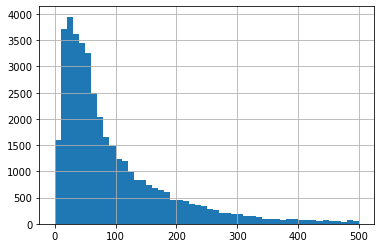

In [46]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in final['comment']]
pd.Series(seq_len).hist(bins = 50,range=[0,500])

In [66]:
# Model parameter
MAX_SEQ_LEN = 300
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('comment', text_field),('toxicity', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv',
                                           test='test.csv', format='CSV', fields=fields, skip_header=True)


train_iter = BucketIterator(train, batch_size=8, sort_key=lambda x: len(x.comment),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=8, sort_key=lambda x: len(x.comment),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=8, device=device, train=False, shuffle=False, sort=False)

In [68]:
# model import 
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]
        

        return loss, text_fea

In [73]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [76]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0 
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        batch_no = 1
        for (comment, toxicity), _ in train_loader:
            toxicity = toxicity.type(torch.LongTensor)           
            toxicity = toxicity.to(device)
            comment = comment.type(torch.LongTensor)  
            comment = comment.to(device)
            output = model(comment, toxicity)
            loss, _ = output
            print('batch_no [{}/{}]:'.format(batch_no, int(len(train_comment)/16)),'training_loss:',loss)
            batch_no+=1
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (comment, toxicity), _ in valid_loader:
                        toxicity = toxicity.type(torch.LongTensor)           
                        toxicity = toxicity.to(device)
                        comment = comment.type(torch.LongTensor)  
                        comment = comment.to(device)
                        output = model(comment, toxicity)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [77]:
from transformers import AdamW
model = BERT().to(device)
no_decay = ['bias', 'LayerNorm.weight']    
optimizer_grouped_parameters = [
{'params': [p for n,p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
{'params': [p for n,p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5)
train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Streaming output truncated to the last 5000 lines.
batch_no [3319/2078]: training_loss: tensor(0.0029, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3320/2078]: training_loss: tensor(0.0016, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3321/2078]: training_loss: tensor(0.0028, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3322/2078]: training_loss: tensor(0.0057, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3323/2078]: training_loss: tensor(0.0268, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3324/2078]: training_loss: tensor(0.0263, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3325/2078]: training_loss: tensor(0.0045, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3326/2078]: training_loss: tensor(0.0018, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3327/2078]: training_loss: tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3328/2078]: training_loss: tensor(0.0014, device='cuda:0', grad_fn=<NllLoss

Model loaded from <== Model/metrics.pt


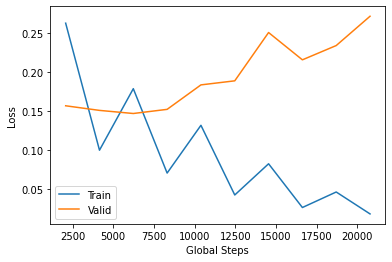

In [79]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [80]:
from sklearn.metrics import roc_curve
def evaluate(model, test_loader):
    y_pred = []
    y_true = []
    y_prob = []
    model.eval()
    with torch.no_grad():
        for (comment,attack ), _ in test_loader:

                comment = comment.type(torch.LongTensor)           
                comment = comment.to(device)
                attack = attack.type(torch.LongTensor)  
                attack = attack.to(device)
                output = model(comment, attack)

                _, output = output
                y_prob.extend(output.tolist())
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(attack.tolist())
    return y_true, y_pred,y_prob    

In [82]:
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

y_true, y_pred,y_prob = evaluate(best_model, test_iter)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== Model/model.pt


In [86]:
label_true = []
for i in y_true:
    if i == 1:
        label_true.append([1,0])
    else:
        label_true.append([0,1])

y_prob_final = []
for i in range(len(y_prob)):
    tempA = abs(y_prob[i][0])
    tempB = abs(y_prob[i][1])
    y_prob_final.append(tempA/(tempA+tempB))

Classification Report:
              precision    recall  f1-score   support

           1     0.6852    0.3279    0.4436       677
           0     0.9430    0.9866    0.9643      7635

    accuracy                         0.9330      8312
   macro avg     0.8141    0.6573    0.7040      8312
weighted avg     0.9220    0.9330    0.9219      8312



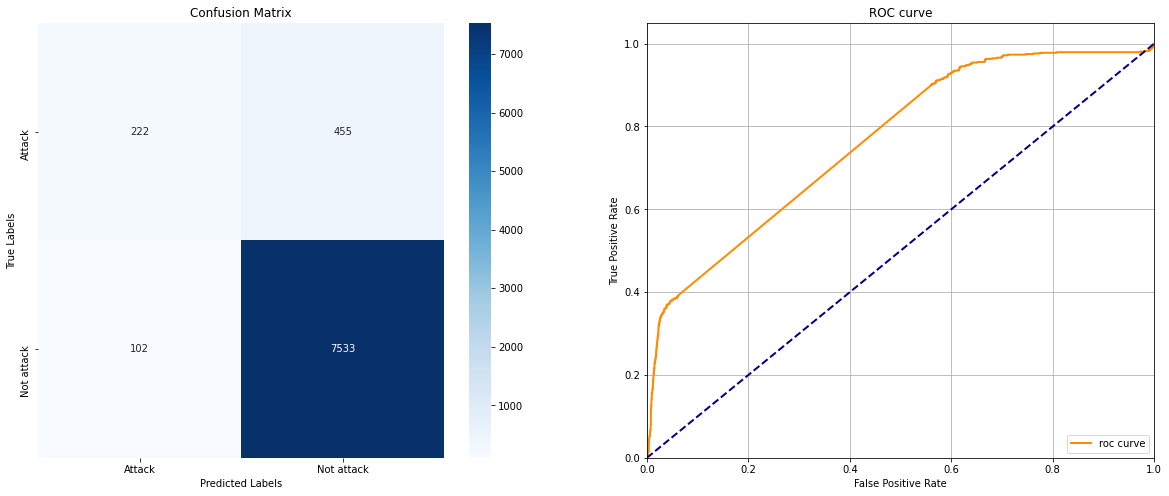

auc score: 0.6572788768199006


In [88]:
# in domain test
from sklearn.metrics import roc_auc_score
print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[1,0])
plt.figure(1, figsize=(20,8))

ax= plt.subplot(121)
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(['Attack', 'Not attack'])
ax.yaxis.set_ticklabels(['Attack', 'Not attack'])
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_true, y_prob_final)
plt.subplot(122)
lw = 2
plt.plot(fpr_rt_lm, tpr_rt_lm, color='darkorange',
         lw=lw, label='roc curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

print('auc score:', roc_auc_score(y_true, y_pred))

In [92]:
# test on 2400 hand labelled data
# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('comment', text_field),('toxicity', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv',
                                           test='test5.csv', format='CSV', fields=fields, skip_header=True)


test_iter = Iterator(test, batch_size=8, device=device, train=False, shuffle=False, sort=False)


In [93]:
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

y_true, y_pred,y_prob = evaluate(best_model, test_iter)

label_true = []
for i in y_true:
    if i == 1:
        label_true.append([1,0])
    else:
        label_true.append([0,1])
        

y_prob_final = []
for i in range(len(y_prob)):
    tempA = abs(y_prob[i][0])
    tempB = abs(y_prob[i][1])
    y_prob_final.append(tempA/(tempA+tempB))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== Model/model.pt


Classification Report:
              precision    recall  f1-score   support

           1     0.4355    0.4233    0.4293       678
           0     0.7645    0.7733    0.7689      1641

    accuracy                         0.6710      2319
   macro avg     0.6000    0.5983    0.5991      2319
weighted avg     0.6683    0.6710    0.6696      2319



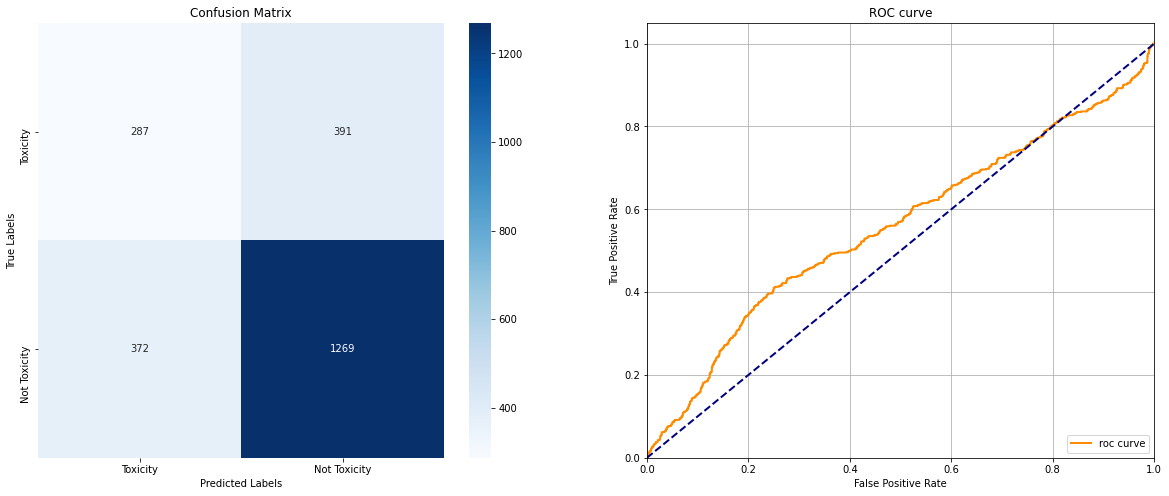

auc score: 0.5983063963803638


In [94]:
# test on 2400 hand labelled data
from sklearn.metrics import roc_auc_score
print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[1,0])
plt.figure(1, figsize=(20,8))

ax= plt.subplot(121)
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(['Toxicity', 'Not Toxicity'])
ax.yaxis.set_ticklabels(['Toxicity', 'Not Toxicity'])
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_true, y_prob_final)
plt.subplot(122)
lw = 2
plt.plot(fpr_rt_lm, tpr_rt_lm, color='darkorange',
         lw=lw, label='roc curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

# auc score
print('auc score:', roc_auc_score(y_true, y_pred))